# Pengembangan Sistem Deteksi Anomali pada Data Sensor IoT menggunakan Arsitektur Hybrid CNN‑LSTM

In [1]:
!pip install kaggle seaborn

# Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Download Dataset dari Kaggle

In [3]:
from google.colab import files
files.upload()   # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atikaoktavianti","key":"e7054724caf6c127e3e103ea57b1f37c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d garystafford/environmental-sensor-data-132k
!unzip environmental-sensor-data-132k.zip

Dataset URL: https://www.kaggle.com/datasets/garystafford/environmental-sensor-data-132k
License(s): CC0-1.0
  0% 0.00/6.74M [00:00<?, ?B/s]
100% 6.74M/6.74M [00:00<00:00, 1.11GB/s]
Archive:  environmental-sensor-data-132k.zip
  inflating: iot_telemetry_data.csv  


## Load Dataset

In [6]:
df = pd.read_csv("iot_telemetry_data.csv")
df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   motion    405184 non-null  bool   
 7   smoke     405184 non-null  float64
 8   temp      405184 non-null  float64
dtypes: bool(2), float64(6), object(1)
memory usage: 22.4+ MB


In [8]:
df.describe()

,ts,co,humidity,lpg,smoke,temp
count,4.051840e+05,405184.000000,405184.000000,405184.000000,405184.000000,405184.000000
mean,1.594858e+09,0.004639,60.511694,0.007237,0.019264,22.453987
std,1.994984e+05,0.001250,11.366489,0.001444,0.004086,2.698347
min,1.594512e+09,0.001171,1.100000,0.002693,0.006692,0.000000
25%,1.594686e+09,0.003919,51.000000,0.006456,0.017024,19.900000
50%,1.594858e+09,0.004812,54.900000,0.007489,0.019950,22.200000
75%,1.595031e+09,0.005409,74.300003,0.008150,0.021838,23.600000
max,1.595203e+09,0.014420,99.900002,0.016567,0.046590,30.600000


# Pra-pemrosesan Data

Seleksi fitur sensor

In [9]:
sensor_features = [
    "temp", "humidity", "co", "lpg", "smoke"
]

df_sensor = df[sensor_features].copy()

handling missing values

In [10]:
df_sensor.isnull().sum()

,0
temp,0
humidity,0
co,0
lpg,0
smoke,0


In [11]:
df_sensor = df_sensor.fillna(method="ffill")

/tmp/ipython-input-885939362.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sensor = df_sensor.fillna(method="ffill")


**Pembuatan Label Anomali**

In [12]:
from scipy.stats import zscore

z_scores = np.abs(zscore(df_sensor))

In [13]:
df["anomaly"] = (z_scores > 3).any(axis=1).astype(int)

In [14]:
df["anomaly"].value_counts()

,count
anomaly,
0,401736
1,3448


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   motion    405184 non-null  bool   
 7   smoke     405184 non-null  float64
 8   temp      405184 non-null  float64
 9   anomaly   405184 non-null  int64  
dtypes: bool(2), float64(6), int64(1), object(1)
memory usage: 25.5+ MB


## Eksplorasi Data (EDA)

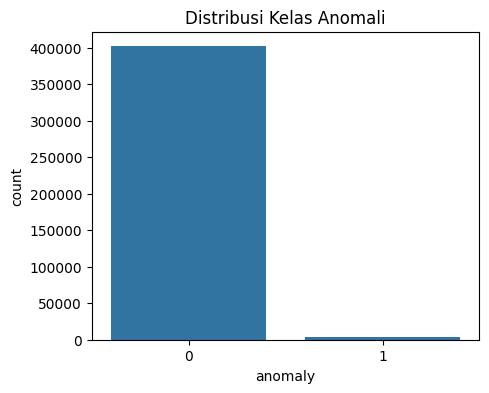

In [16]:
plt.figure(figsize=(5,4))
sns.countplot(x="anomaly", data=df)
plt.title("Distribusi Kelas Anomali")
plt.show()

**Visualisasi Sensor vs Anomali**

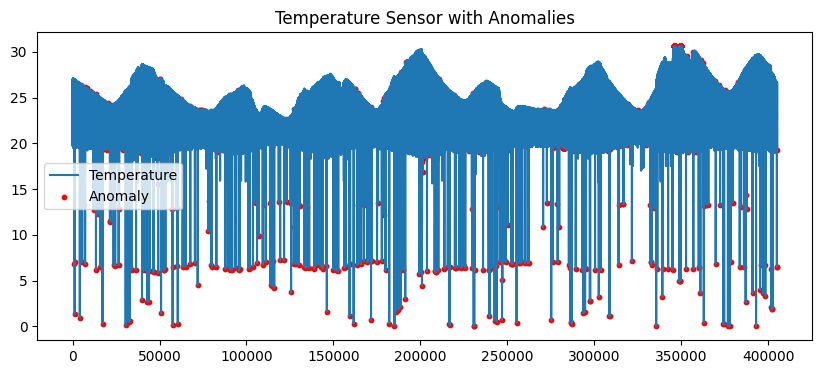

In [17]:
plt.figure(figsize=(10,4))
plt.plot(df["temp"], label="Temperature")
plt.scatter(
    df.index[df["anomaly"] == 1],
    df["temp"][df["anomaly"] == 1],
    color="red", label="Anomaly", s=10
)
plt.legend()
plt.title("Temperature Sensor with Anomalies")
plt.show()

**Normalisasi Data**

In [18]:
from sklearn.preprocessing import StandardScaler

X = df[sensor_features].values
y = df["anomaly"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**WINDOWING (SEKUENS TIME SERIES)**

In [19]:
def create_sequences(X, y, window_size=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

WINDOW_SIZE = 30
X_seq, y_seq = create_sequences(X_scaled, y, WINDOW_SIZE)

X_seq.shape, y_seq.shape

((405154, 30, 5), (405154,))

**SPLIT DATA (70 / 15 / 15)**

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_seq, y_seq,
    test_size=0.30,
    random_state=42,
    stratify=y_seq
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

**CLASS WEIGHT (IMBALANCED DATA)**

In [21]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight = {
    0: weights[0],
    1: weights[1]
}

class_weight

{0: np.float64(0.5042924254871209), 1: np.float64(58.74212924606462)}

# Modelling

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [23]:
model = Sequential([
    Conv1D(64, 3, activation="relu",
           input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling1D(2),

    LSTM(64),
    Dropout(0.5),

    Dense(64, activation="relu"),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**COMPILE MODEL (FOCAL LOSS TANPA ADDONS)**

In [24]:
import tensorflow as tf
from tensorflow.keras import backend as K

def binary_focal_loss(alpha=0.75, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return tf.reduce_mean(
            -alpha * tf.pow(1 - p_t, gamma) * tf.math.log(p_t)
        )
    return loss

In [25]:
model.compile(
    optimizer="adam",
    loss=binary_focal_loss(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,129 (313.00 KB)

 Trainable params: 79,745 (311.50 KB)

 Non-trainable params: 384 (1.50 KB)

## Training

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("cnn_lstm_iot.h5", save_best_only=True)
]

In [27]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=128,
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 1/40
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9894 - loss: 0.0114

2216/2216 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9894 - loss: 0.0114 - val_accuracy: 0.9915 - val_loss: 0.0073
Epoch 2/40
2213/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9914 - loss: 0.0086

2216/2216 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9914 - loss: 0.0086 - val_accuracy: 0.9908 - val_loss: 0.0062
Epoch 3/40
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9913 - loss: 0.0079 - val_accuracy: 0.9916 - val_loss: 0.0064
Epoch 4/40
2213/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9914 - loss: 0.0077

2216/2216 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9914 - loss: 0.0077 - val_accuracy: 0.9918 - val_loss: 0.0055
Epoch 5/40
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.9912 - loss: 0.0074 - val_accuracy: 0.9916 - val_loss: 0.0056
Epoch 6/40
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9912 - loss: 0.0072

2216/2216 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9912 - loss: 0.0072 - val_accuracy: 0.9918 - val_loss: 0.0051
Epoch 7/40
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.9914 - loss: 0.0070 - val_accuracy: 0.9904 - val_loss: 0.0056
Epoch 8/40
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - accuracy: 0.9913 - loss: 0.0068 - val_accuracy: 0.9912 - val_loss: 0.0057
Epoch 9/40
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.9913 - loss: 0.0067 - val_accuracy: 0.9913 - val_loss: 0.0053
Epoch 10/40
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9911 - loss: 0.0064 - val_accuracy: 0.9915 - val_loss: 0.0053
Epoch 11/40
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.9905 - loss: 0.0069 - val_accuracy: 0.9909 - val_loss: 0.0057


In [29]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.3).astype(int)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob))

1900/1900 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step
Accuracy : 0.9798927172804159
Precision: 0.28173374613003094
Recall   : 0.8800773694390716
F1-score : 0.4268292682926829
ROC-AUC  : 0.9579411771031425


**Confusion Matrix**

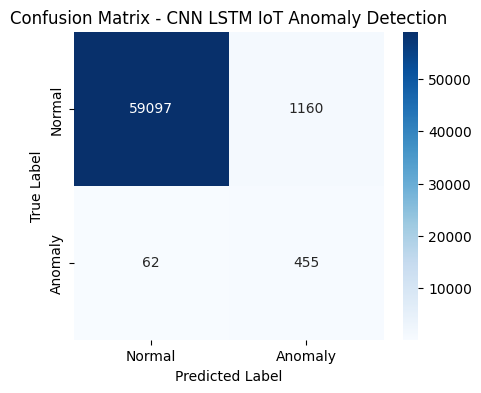

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2️⃣ Tampilkan heatmap
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Anomaly"],
    yticklabels=["Normal", "Anomaly"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CNN LSTM IoT Anomaly Detection")
plt.show()

In [31]:
# Prediksi probabilitas untuk kelas 1 (anomaly)
y_prob = model.predict(X_test).ravel()
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print("ROC-AUC:", roc_auc)

1900/1900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
ROC-AUC: 0.9579411771031425


**ROC Curve**

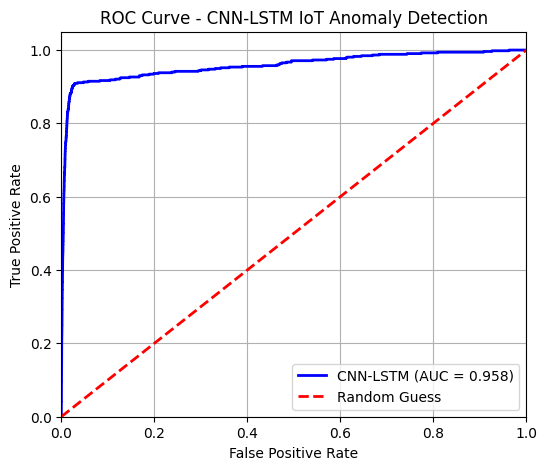

In [32]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label='CNN-LSTM (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN-LSTM IoT Anomaly Detection')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Baseline 1: OneClass SVM

In [33]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Flatten windowed data untuk SVM
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Gunakan hanya data normal untuk training
X_train_normal = X_train_flat[y_train == 0]

# Inisialisasi OneClass SVM
svm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")  # nu = proporsi anomaly
svm.fit(X_train_normal)

# Prediksi
y_pred_svm = svm.predict(X_test_flat)
# OneClassSVM output: 1 = normal, -1 = anomaly → sesuaikan
y_pred_svm = np.where(y_pred_svm == 1, 0, 1)

# Evaluasi
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm, zero_division=0)
rec_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_svm = roc_auc_score(y_test, y_pred_svm)

print("OneClass SVM Baseline:")
print(f"Accuracy : {acc_svm:.4f}")
print(f"Precision: {prec_svm:.4f}")
print(f"Recall   : {rec_svm:.4f}")
print(f"F1-score : {f1_svm:.4f}")
print(f"ROC-AUC  : {roc_svm:.4f}")

OneClass SVM Baseline:
Accuracy : 0.9471
Precision: 0.1089
Recall   : 0.7253
F1-score : 0.1893
ROC-AUC  : 0.8372


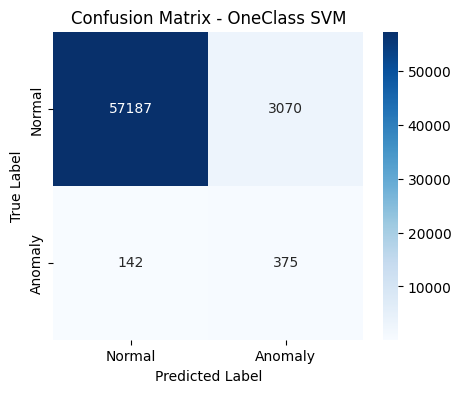

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Visualisasi heatmap
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Anomaly"],
    yticklabels=["Normal", "Anomaly"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - OneClass SVM")
plt.show()

## Baseline 2: Autoencoder

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Flatten windowed data
input_dim = X_train.shape[1] * X_train.shape[2]
X_train_flat = X_train.reshape(len(X_train), input_dim)
X_test_flat = X_test.reshape(len(X_test), input_dim)

# Gunakan hanya data normal untuk training
X_train_normal_flat = X_train_flat[y_train == 0]

# Bangun Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation="relu")(input_layer)
encoded = Dense(64, activation="relu")(encoded)
decoded = Dense(128, activation="relu")(encoded)
decoded = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Training
history_ae = autoencoder.fit(
    X_train_normal_flat, X_train_normal_flat,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

# Prediksi reconstruction
reconstructions = autoencoder.predict(X_test_flat)
mse = np.mean(np.power(X_test_flat - reconstructions, 2), axis=1)

# Tentukan threshold anomaly (misal 95 percentile dari data training normal)
train_recon = autoencoder.predict(X_train_normal_flat)
threshold = np.percentile(np.mean(np.power(X_train_normal_flat - train_recon, 2), axis=1), 95)

# Prediksi label anomaly
y_pred_ae = (mse > threshold).astype(int)

# Evaluasi
acc_ae = accuracy_score(y_test, y_pred_ae)
prec_ae = precision_score(y_test, y_pred_ae, zero_division=0)
rec_ae = recall_score(y_test, y_pred_ae)
f1_ae = f1_score(y_test, y_pred_ae)
roc_ae = roc_auc_score(y_test, mse)  # pakai probabilitas MSE

print("Autoencoder Baseline:")
print(f"Accuracy : {acc_ae:.4f}")
print(f"Precision: {prec_ae:.4f}")
print(f"Recall   : {rec_ae:.4f}")
print(f"F1-score : {f1_ae:.4f}")
print(f"ROC-AUC  : {roc_ae:.4f}")

Epoch 1/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2796 - val_loss: 0.0532
Epoch 2/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0501 - val_loss: 0.0479
Epoch 3/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0465 - val_loss: 0.0471
Epoch 4/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0458 - val_loss: 0.0468
Epoch 5/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0455 - val_loss: 0.0463
Epoch 6/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0453 - val_loss: 0.0452
Epoch 7/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0452 - val_loss: 0.0455
Epoch 8/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0448 - val_loss: 0.0457
Epoch 9/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0449 - val_loss: 0.0462
Epoch 10/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0450 - val_loss: 0.0467
Epoch 11/30
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0449 - val_loss: 0.0452
Epoch 12/30
1978/1978 ━━━━━━

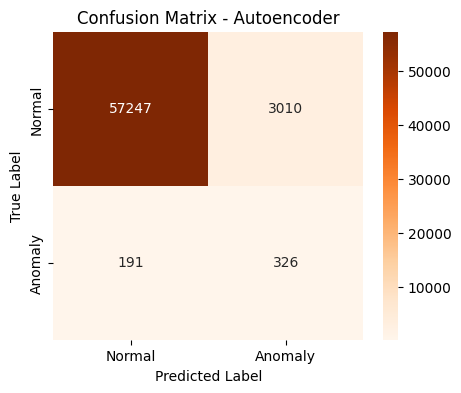

In [41]:
# Confusion matrix
cm_ae = confusion_matrix(y_test, y_pred_ae)

# Visualisasi heatmap
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_ae,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=["Normal", "Anomaly"],
    yticklabels=["Normal", "Anomaly"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Autoencoder")
plt.show()

## Random search untuk CNN-LSTM

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, MaxPooling1D
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import f1_score

#  Definisi Custom Loss Function
from tensorflow.keras import backend as K

def binary_focal_loss(alpha=0.75, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return tf.reduce_mean(
            -alpha * tf.pow(1 - p_t, gamma) * tf.math.log(p_t)
        )
    return loss

#  Hyperparameter Space
param_grid = {
    "filters1": [32, 64],
    "filters2": [64, 128],
    "kernel_size": [3, 5],
    "lstm_units": [32, 64],
    "dropout1": [0.3, 0.5],
    "dropout2": [0.2, 0.3]
}

param_list = list(ParameterSampler(param_grid, n_iter=5, random_state=42))

# =======================================
#  Random Search Loop
best_f1 = 0
best_params = None
best_model = None

input_shape = (X_train.shape[1], X_train.shape[2])  # Sesuaikan dengan dataset windowed Anda

for i, params in enumerate(param_list):
    print(f"\n===== Percobaan {i+1} dengan parameter: {params} =====")

    # Build Model CNN-LSTM sesuai hyperparameter
    model = Sequential([
        Conv1D(params["filters1"], params["kernel_size"], activation="relu",
               input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(params["filters2"], params["kernel_size"], activation="relu"),
        BatchNormalization(),
        MaxPooling1D(2),

        LSTM(params["lstm_units"]),
        Dropout(params["dropout1"]),

        Dense(64, activation="relu"),
        Dropout(params["dropout2"]),

        Dense(1, activation="sigmoid")
    ])

    # Compile dengan custom focal loss
    model.compile(optimizer="adam",
                  loss=binary_focal_loss(alpha=0.75, gamma=2.0),
                  metrics=["accuracy"])

    # Train singkat (misal 10 epoch untuk tuning cepat)
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=10,
                        batch_size=128,
                        verbose=0)

    # Prediksi validation set
    y_val_pred = (model.predict(X_val) > 0.5).astype(int)

    # Hitung F1-score
    f1 = f1_score(y_val, y_val_pred)
    print(f"F1-score: {f1:.4f}")

    # Update best model
    if f1 > best_f1:
        best_f1 = f1
        best_params = params
        best_model = model

print("\n===== Hasil Hyperparameter Tuning =====")
print("Best F1-score:", best_f1)
print("Best parameters:", best_params)

#4 Simpan Best Model
best_model.save("best_cnn_lstm_model.h5")
print("Best model disimpan sebagai best_cnn_lstm_model.h5")


===== Percobaan 1 dengan parameter: {'lstm_units': 32, 'kernel_size': 3, 'filters2': 128, 'filters1': 32, 'dropout2': 0.3, 'dropout1': 0.5} =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1900/1900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
F1-score: 0.1250

===== Percobaan 2 dengan parameter: {'lstm_units': 32, 'kernel_size': 5, 'filters2': 64, 'filters1': 64, 'dropout2': 0.3, 'dropout1': 0.5} =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1900/1900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
F1-score: 0.0000

===== Percobaan 3 dengan parameter: {'lstm_units': 32, 'kernel_size': 3, 'filters2': 64, 'filters1': 32, 'dropout2': 0.2, 'dropout1': 0.3} =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1900/1900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
F1-score: 0.0930

===== Percobaan 4 dengan parameter: {'lstm_units': 32, 'kernel_size': 3, 'filters2': 128, 'filters1': 64, 'dropout2': 0.2, 'dropout1': 0.5} =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1900/1900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
F1-score: 0.2783

===== Percobaan 5 dengan parameter: {'lstm_units': 64, 'kernel_size': 3, 'filters2': 128, 'filters1': 32, 'dropout2': 0.2, 'dropout1': 0.3} =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1900/1900 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


F1-score: 0.0265

===== Hasil Hyperparameter Tuning =====
Best F1-score: 0.2783357245337159
Best parameters: {'lstm_units': 32, 'kernel_size': 3, 'filters2': 128, 'filters1': 64, 'dropout2': 0.2, 'dropout1': 0.5}
Best model disimpan sebagai best_cnn_lstm_model.h5


**Mencoba mendeteksi Model CNN-LSTM dengan data Normal**

In [43]:
from tensorflow.keras.models import load_model

# Load model CNN-LSTM terbaik
model = load_model("best_cnn_lstm_model.h5", compile=False)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])  # loss sesuai training

In [46]:
# Misal model dilatih dengan window_size = 30
window_size = 30
num_features = 5

# Buat data baru menjadi window dengan panjang 30
# Jika kurang, bisa di-pad dengan nilai normal (misal mean 0 setelah scaling)
new_window = np.array([[22.7, 50.0, 0.37, 0.02, 0.0]])  # 1 timestep
padding_needed = window_size - new_window.shape[0]

if padding_needed > 0:
    # pad dengan 0 atau mean dari training
    pad_array = np.zeros((padding_needed, num_features))
    new_window_padded = np.vstack([pad_array, new_window])
else:
    new_window_padded = new_window[-window_size:]  # ambil timesteps terakhir

# Reshape sesuai input CNN-LSTM
new_data = new_window_padded.reshape(1, window_size, num_features)

In [50]:
# Prediksi probabilitas
y_prob = model.predict(new_data).ravel()

# Threshold
threshold = 0.3
y_pred = (y_prob > threshold).astype(int)

status = "Anomaly 🚨" if y_pred[0] == 1 else "Normal ✅"
print("Status:", status)
print("Probabilitas anomaly:", y_prob[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Status: Normal ✅
Probabilitas anomaly: 0.050563596


**Mencoba mendeteksi Model CNN-LSTM dengan data Anomaly**

In [49]:
import numpy as np

# Contoh 1 window anomaly
window_size = 30   # sama dengan saat training
num_features = 5   # jumlah fitur

# Buat anomaly: suhu sangat tinggi + kelembaban rendah
anomaly_window = np.array([[50.0, 10.0, 0.0, 0.5, 1.0]] * window_size)  # ulangi untuk window_size

# Reshape sesuai CNN-LSTM
anomaly_data = anomaly_window.reshape(1, window_size, num_features)

# Prediksi
y_prob = model.predict(anomaly_data).ravel()
threshold = 0.15
y_pred = (y_prob > threshold).astype(int)

status = "Anomaly 🚨" if y_pred[0] == 1 else "Normal ✅"
print("Status:", status)
print("Probabilitas anomaly:", y_prob[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Status: Anomaly 🚨
Probabilitas anomaly: 0.17023705
